In [2]:
 #!pip install --upgrade pip
 #!pip3 install tensorflow
 #!pip3 install torch torchvision

## Time to get your hands dirty. Galaxies vs quasars with neural networks.

Let's go back to our galaxy vs quasar data we've used in a previous exercise. 

1. Read in SDSS galaxy color data from `solutions/galaxyquasar.csv`. Create arrays for the $(u-g)$, $(g-r)$, $(r-i)$, and $(i-z)$ colors. Also create an array with the class labels where galaxy=$0$ and quasar=$1$. 

2. Now we're going to fit a neural network classifier. First, scale your data appropriately and do a 30% train/test split.

3. Now train the classifier. Use one the package among those we've seen. These include Tensorflow via keras, pytorch, and the MPL classifier implemented in scikit-learn. This is an opportunity to pick the one you're most interested in learning. 

3. Start from a network architecture with a single hidden layer with 5 neurons, using the `adam` solver, the `relu` activation function, and a learninig rate of `0.001`. Plot the resulting ROC curve. 

4. Now let's optimize the hyperparameters of your network. Explore different hyperparameters and see what fits the data best.  Do your best now to optimize the network architecture. Be creative!

5. Is your best result comparable with the simpler classifiers we've seen before? Do we need deep learning here? If yes, which features are captured best?


A few tips:

- In scikit-learn, remember that you can utilize all availables cores on your machine with `n_jobs=-1`. Print out the classification score for the training data, and the best parameters obtained by the cross validation.
- If it takes too long, run the hyperparameter optimization on a subset of the training set. Then retrain the full network using the best hyperparameters only.
- On cross validation, for scikit learn we've seen how to use `GridSearchCV` already. For Tensorflow, there's a really cool tool called [Tensorboard](https://www.tensorflow.org/tensorboard)

In [26]:
import setuptools.dist
import tensorflow as tf
from sklearn.metrics import roc_curve, auc
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import os
import deepdish

#import  torch, torchvision

In [11]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

data = pd.read_csv('../solutions/galaxyquasar.csv')

u_g = data['u'] - data['g']
g_r = data['g'] - data['r']
r_i = data['r'] - data['i']
i_z = data['i'] - data['z']

labels = data['class'].apply(lambda x: 0 if x == 'GALAXY' else 1)

features = pd.DataFrame({'u-g': u_g, 'g-r': g_r, 'r-i': r_i, 'i-z': i_z})


In [12]:
data

,u,g,r,i,z,class,z1,zerr
0,18.97213,18.53676,18.58280,18.34936,18.29215,QSO,0.522819,0.000155
1,19.24592,17.47646,16.47817,16.04472,15.68851,GALAXY,0.122846,0.000028
2,19.43536,17.70268,16.91565,16.58327,16.39128,GALAXY,0.000000,0.000000
3,19.31626,18.18312,17.39591,16.94549,16.65395,GALAXY,0.147435,0.000009
4,19.28828,19.11188,18.88937,18.80013,18.49183,QSO,2.011455,0.000631
...,...,...,...,...,...,...,...,...
49995,19.37295,18.12382,17.39886,16.98503,16.70585,GALAXY,0.113016,0.000011
49996,18.52021,16.88262,16.03280,15.56884,15.22454,GALAXY,0.085063,0.000014
49997,18.62718,17.30876,16.87371,16.62399,16.42296,GALAXY,0.054429,0.000008
49998,19.55140,18.27711,17.62101,17.21947,17.03347,GALAXY,0.112571,0.000009


In [13]:
#let's scale them
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

X_train, X_test, y_train, y_test = train_test_split(features_scaled, labels, test_size=0.3, random_state=42)

In [14]:
X_mean = X_train.mean(axis=0, keepdims=True)
X_std = X_train.std(axis=0, keepdims=True) + 1e-7
X_train = (X_train - X_mean) / X_std
X_test = (X_test - X_mean) / X_std
X_test = (X_test - X_mean) / X_std



In [41]:
filename='trained.keras'

if not os.path.isfile(filename):
        
    my_init = keras.initializers.glorot_uniform(seed=1)
    model = keras.Sequential( [
                # Input layer, do not change
                tf.keras.layers.InputLayer(input_shape=np.shape(X_train[0])),
                # Inner layers, can add/change
                keras.layers.Dense(5,  activation='relu',kernel_initializer=my_init),
                #keras.layers.Dense(16,  activation='tanh',kernel_initializer=my_init),
                #keras.layers.Dense(8,  activation='tanh',kernel_initializer=my_init),
                # Output layer, do not change
                keras.layers.Dense(1, activation='sigmoid',kernel_initializer=my_init)])


    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

    def scheduler(epoch, lr):
                if epoch < 10:
                    return float(lr)
                else:
                    return float(lr * tf.math.exp(-0.05))

    # Train the model
    history = model.fit(X_train, y_train,
                        epochs=50, batch_size=10, validation_data=(X_test, y_test),
                        callbacks = [
                            # Drecrease learning rate
                            tf.keras.callbacks.LearningRateScheduler(scheduler),
                            # Store the model with the best validation accuracy
                            tf.keras.callbacks.ModelCheckpoint(
                                filepath=filename,
                                save_weights_only=False,
                                monitor='val_accuracy',
                                mode='max',
                                save_best_only=True),
                            # Save logfiles for tensorboard
                            tf.keras.callbacks.TensorBoard(log_dir="logs"+filename.split('.h5')[0], histogram_freq=1)],
                        
                        # Shuffle data at each epoch
                        shuffle=True)

    # Load the best model
    model = keras.models.load_model(filename)


Epoch 1/50


/home/malvi/venv/lib/python3.12/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


3500/3500 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.8950 - loss: 0.3455 - val_accuracy: 0.9824 - val_loss: 0.0847 - learning_rate: 0.0010
Epoch 2/50
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.9800 - loss: 0.0892 - val_accuracy: 0.9820 - val_loss: 0.0773 - learning_rate: 0.0010
Epoch 3/50
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.9818 - loss: 0.0766 - val_accuracy: 0.9819 - val_loss: 0.0755 - learning_rate: 0.0010
Epoch 4/50
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.9819 - loss: 0.0725 - val_accuracy: 0.9819 - val_loss: 0.0757 - learning_rate: 0.0010
Epoch 5/50
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.9798 - loss: 0.0788 - val_accuracy: 0.9832 - val_loss: 0.0746 - learning_rate: 0.0010
Epoch 6/50
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.9817 - loss: 0.0834 - val_accuracy: 0.9833 - val_loss: 0.0745 - learning_rate: 0.0010
Epoch 7/50
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.9830 - loss: 0.0718

In [33]:
# Predict probabilities
y_pred_prob = model.predict(X_test).ravel()  #(ravel flattens the array), can also use squeeze


469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


In [34]:
# Save model
model.save("my_keras_model.keras")

# Reload model
model = keras.models.load_model("my_keras_model.keras")

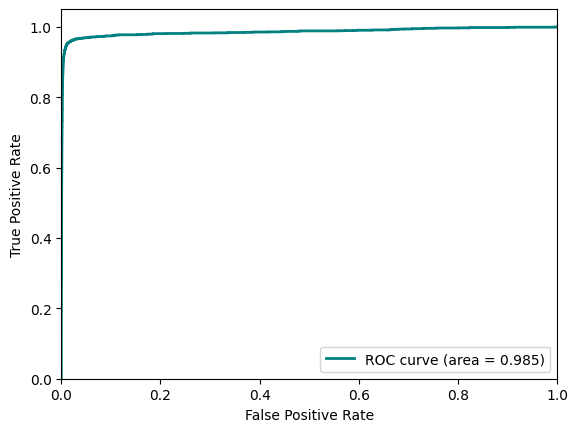

In [39]:
# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='teal', lw=2, label='ROC curve (area = %0.3f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

In [42]:
# print the classification score:

print('Classification score: ', model.evaluate(X_test, y_test)[1])

469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9827 - loss: 0.0771
Classification score:  0.9839333295822144


## Let's now find the best hyperparameters for the network, cross validation with Tensorboard:

In [44]:
import keras_tuner as kt

def build_model(hp):
    model = keras.Sequential()
    
    model.add(tf.keras.layers.InputLayer(input_shape=np.shape(X_train[0])))
    
    # Tune the number of units in the first Dense layer
    hp_units = hp.Int('units', min_value=5, max_value=50, step=5)
    model.add(keras.layers.Dense(units=hp_units, activation='relu', kernel_initializer=my_init))
    
    # Tune the learning rate for the optimizer
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    
    model.add(keras.layers.Dense(1, activation='sigmoid', kernel_initializer=my_init))
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

tuner = kt.Hyperband(build_model,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='my_dir',
                     project_name='intro_to_kt')

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

tuner.search(X_train, y_train, epochs=50, validation_data=(X_test, y_test), callbacks=[stop_early, tf.keras.callbacks.TensorBoard(log_dir="logs/hparam_tuning")])

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")

Trial 30 Complete [00h 00m 25s]
val_accuracy: 0.9843999743461609

Best val_accuracy So Far: 0.9850666522979736
Total elapsed time: 00h 05m 56s

The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 15 and the optimal learning rate for the optimizer
is 0.01.



In [48]:
from tensorflow.keras.callbacks import TensorBoard

# Import TensorBoard

# Define the log directory
log_dir = "logs/hparam_tuning"

# Create a TensorBoard callback
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

# Use the TensorBoard callback in the tuner search
tuner.search(X_train, y_train, epochs=50, validation_data=(X_test, y_test), callbacks=[stop_early, tensorboard_callback])

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")


The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 15 and the optimal learning rate for the optimizer
is 0.01.

